# CS684 Final Project - Project 2
### Name: Kyu Min Shim
### UW email: kmshim@uwaterloo.ca

## Abstract: 
For the final project of this course, I chose Project 2 and implemented a full-grid stereo. PyMaxflow library was used to setup the graph and solve for minimum st-cut corresponding to the optimal disparity levels for each pixel that minimize both the photo consistency cost and spatial coherence cost. Tsukuba images from the Middleburry dataset was used for ease of comparison with the results from A3. My own code from A3 were used to rebuild examples of scanline stereo disparity maps. 

The results of the full-grid stereo is fantastic. There is no horizontal streaking artifacts in the full-grid stereo which were present in the scanline stereo with Viterbi. By tuning the hyperparameters, the disparity map from full-grid stereo can be made very smooth and not noisy, while maintaining crisp outlines of objects at every disparity level. The full-grid stereo seems to run faster than the scanline stereo, which is likely due to the highly optimized implementation of the PyMaxflow package. 

## Code Libraries

- Numpy is necessary for storing and processing image as a numpy array
- Matplotlib is necessary to plot disparity maps
- Sys and os is necessary to read in my own library of code: disparity_functions
- Disparity_functions is my own code library which includes functions from A3 which is necessary to compare the results between scanline stereo and full-grid stereo
- Maxflow is necessary to find the minimum st-cut in full-grid stereo that presents optimal disparity map

## Introduction
In the first section of the notebook, we load the necessary code libraries and stereo images to be used in this project. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
from matplotlib.colors import LogNorm
import sys
import os
mylibs_path = os.path.abspath("mylibs")
sys.path.append(mylibs_path)
from disparity_functions import *
import maxflow

For this project, we use the Tsukuba images from the Middleburry dataset, which is the same dataset used in A3. This will make the comparison between two results much easier. The cell below loads in the left image, right image, and the ground truth disparity map.

In [2]:
# load images
im_left = image.imread("images/scene1.row3.col3.ppm")
im_right = image.imread("images/scene1.row3.col4.ppm")
im_gt = image.imread("images/truedisp.row3.col3.pgm")

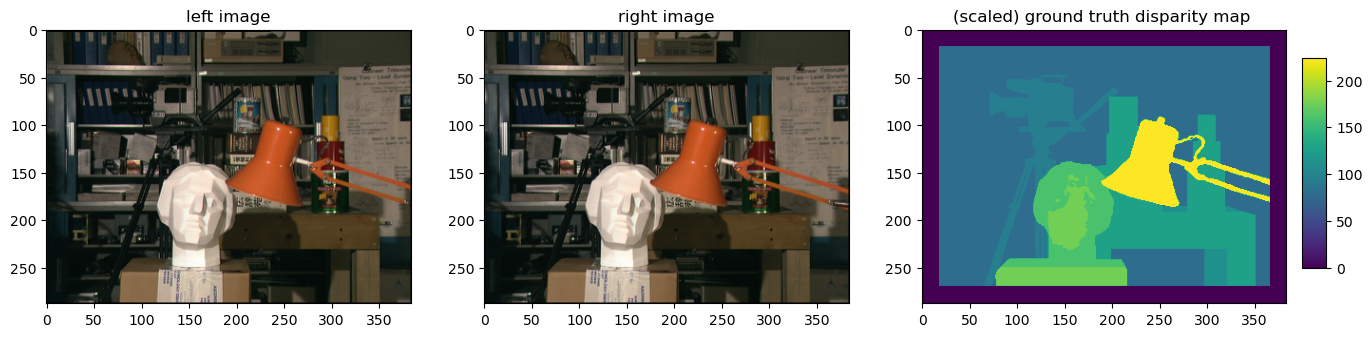

In [3]:
fig = plt.figure(figsize = (16,7))
plt.subplot(131)
plt.title("left image")
plt.imshow(im_left)
plt.subplot(132)
plt.title("right image")
plt.imshow(im_right)
plt.subplot(133) 
plt.title("(scaled) ground truth disparity map ")
plt.imshow(im_gt)
plt.colorbar(cax=plt.axes([0.91, 0.35, 0.015, 0.3]))

Since we know that the scale applied to ground truth disparity map is 16 from A3, we can again calculate for the minimum and maximum disparity values. Note that for minimum disparity, we ignore the 0 valued margin. 

In [4]:
d_min = int(im_gt[im_gt > 0].min())//16
d_max = int(im_gt.max())//16
d_min, d_max

(5, 14)

## Full-grid stereo implementation
Let's move on to the implementation of full-grid stereo using graphs. In the cell below, you can see the full implementation of full0grid stereo using PyMaxflow library. The comments within the code details the purpose of each line within the implementation. 

In [5]:
def disparity_grid(imageL, imageR, d_minimum, d_maximum, sigma, w):
    # weights for vertical edges representing photo consistency costs taken from SD
    SD = SD_array(imageL, imageR, d_minimum, d_maximum)
   
    # weights for each layer, spatial consistency cost defined by local intensity contrast using Gaussian kernel.
    # along horizontal scanline
    n_right = w * np.exp(-np.square(np.linalg.norm(imageL - np.roll(imageL, -1, axis = 1),
                                                      axis=2))/(2*sigma**2))
    # along vertial scanline
    n_below = w * np.exp(-np.square(np.linalg.norm(imageL - np.roll(imageL, -1, axis = 0),
                                                      axis=2))/(2*sigma**2))
    # initialize graph object 
    im_width = imageL.shape[1]
    im_height = imageL.shape[0]
    disp_levels = d_maximum - d_minimum
    g = maxflow.GraphFloat()
    nodeids = g.add_grid_nodes((im_width, im_height, disp_levels))
    
    # set up edges between pixels along vertical scanline
    v_structure = np.array(
        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
         [[0, 0, 0],
          [0, 0, 0],
          [0, 1, 0]],
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]])
    
    # for each disparity level, the weights between the same pixels remain the same
    vertical_layer = np.array([n_below for i in range(disp_levels)])
    g.add_grid_edges(nodeids, weights = np.transpose(vertical_layer), structure = v_structure, symmetric=True)
    
    # set up edges between pixels along horizontal scanline
    h_structure = np.array(
        [[[0, 0, 0],
          [0, 1, 0],
          [0, 0, 0]],
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]])
    
    # for each disparity level, the weights between the same pixels remain the same
    horizontal_layer = np.array([n_right for i in range(disp_levels)])
    g.add_grid_edges(nodeids, weights = np.transpose(horizontal_layer), structure = h_structure, symmetric=True)

    # set up edges between each disparity level layers
    d_structure = np.array(
        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
         [[0, 0, 0],
          [0, 0, 1],
          [0, 0, 0]],
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]])

    # for edges between each disparity level, apply the photo consistency cost given by the SSD
    levels_disp = SD[1:]
    g.add_grid_edges(nodeids, weights = np.transpose(levels_disp), structure = d_structure, symmetric=False)
    
    # set up edges from source node representing SSD at minimum disparity
    g.add_grid_tedges(nodeids[:,:,0], np.transpose(SD[0]), 0)
    # set up edges to sink node representing SSD at maximum disparity
    g.add_grid_tedges(nodeids[:,:,-1], 0, np.transpose(SD[-1]))
    
    # set up edges going reverse in disparity levels with inifinte weight to avoid folding
    f_structure = np.array(
        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
         [[0, 0, 0],
          [1, 0, 0],
          [0, 0, 0]],
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]])
    g.add_grid_edges(nodeids, weights = np.inf, structure = f_structure, symmetric=False)
    
    # solve for minimum st-cut
    g.maxflow()
    
    # retrieve max flow result and transpose so that first dim is layers of disparities
    res = np.transpose(g.get_grid_segments(nodeids))
    
    # get disparity levels for each pixel
    disparity_levels = (disp_levels-np.sum(res, axis=0)) + d_minimum
    
    return disparity_levels

Let's review some results of the full-grid stereo implmenetation and try to tune the hyperparameters $\sigma$ and $w$. We will compare the results for each pair of hyperparameter values and choose the best one to compare with other implementations in the following sections. 

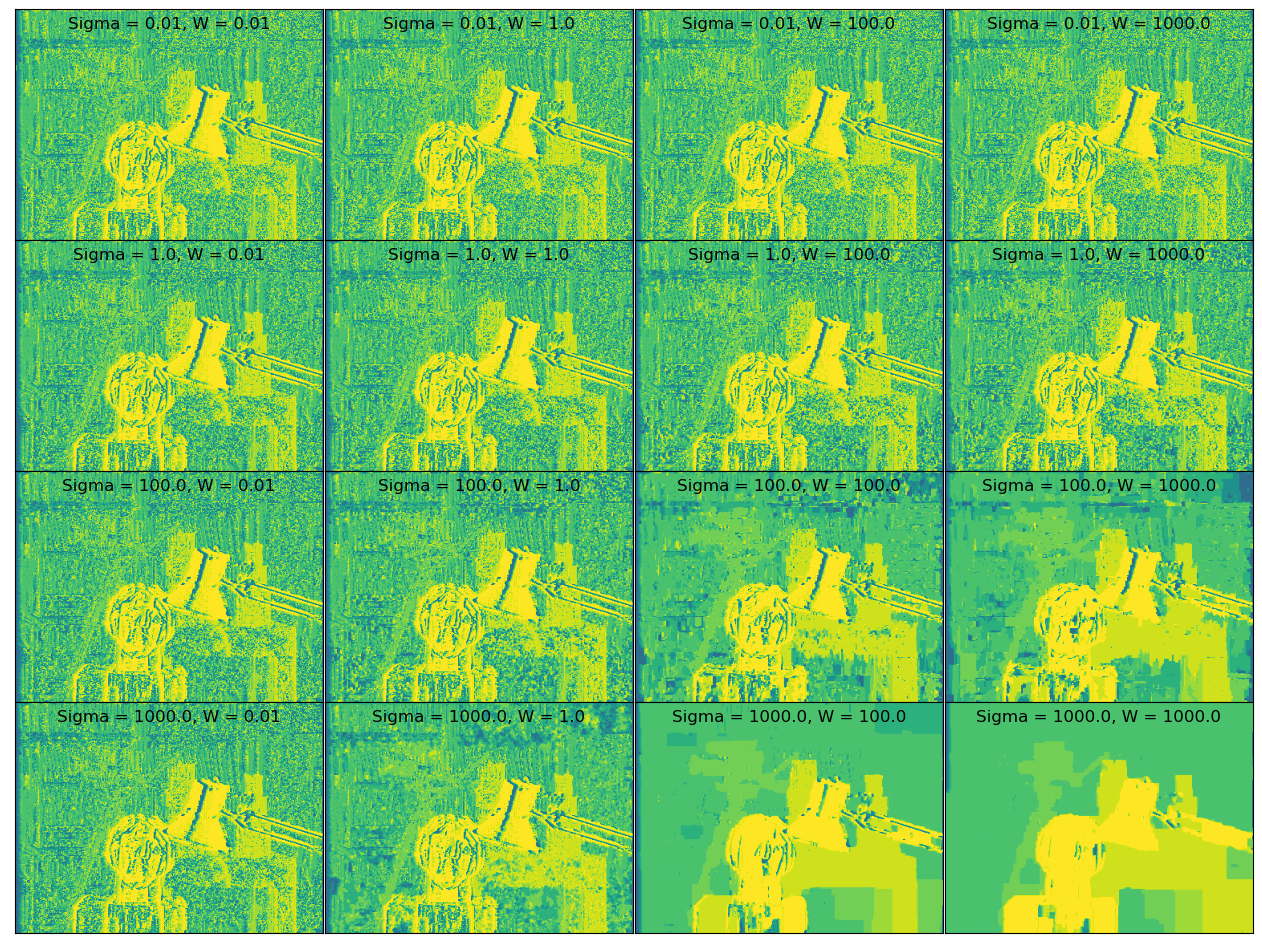

In [6]:
sigmas = np.array([0.01, 1, 100, 1000])
ws = np.array([0.01, 1, 100, 1000])

# use nested forloops for plotting results of full-grid stereo
# each forloop is of short fixed length (4) so not concerned about runtime, this is just for plotting
fig = plt.figure(figsize = (16,12))
for i in range(len(sigmas)):
    for j in range(len(ws)):
        res = disparity_grid(im_left, im_right, d_min, d_max, sigmas[i], ws[j])
        plt.subplot2grid((4,4), (i,j))
        ax = plt.gca()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        plt.title("Sigma = {0}, W = {1}".format(sigmas[i], ws[j]), y = 1, pad=-14)
        plt.imshow(res, vmin=0, vmax=d_max)
plt.subplots_adjust(wspace=0, hspace=0)

It appears that the result of full-grid stereo is quite noisy when at least one of $\sigma$ and $w$ is small, but as they both increase in value, the result becomes much more smooth. In particular, the result for $\sigma = 1000, w = 100$ and $\sigma = 1000, w = 1000$ resembles the ground truth disparity map the most. The cell below compares these two best results and another result with $\sigma = 1000, w = 500$ with the ground truth.

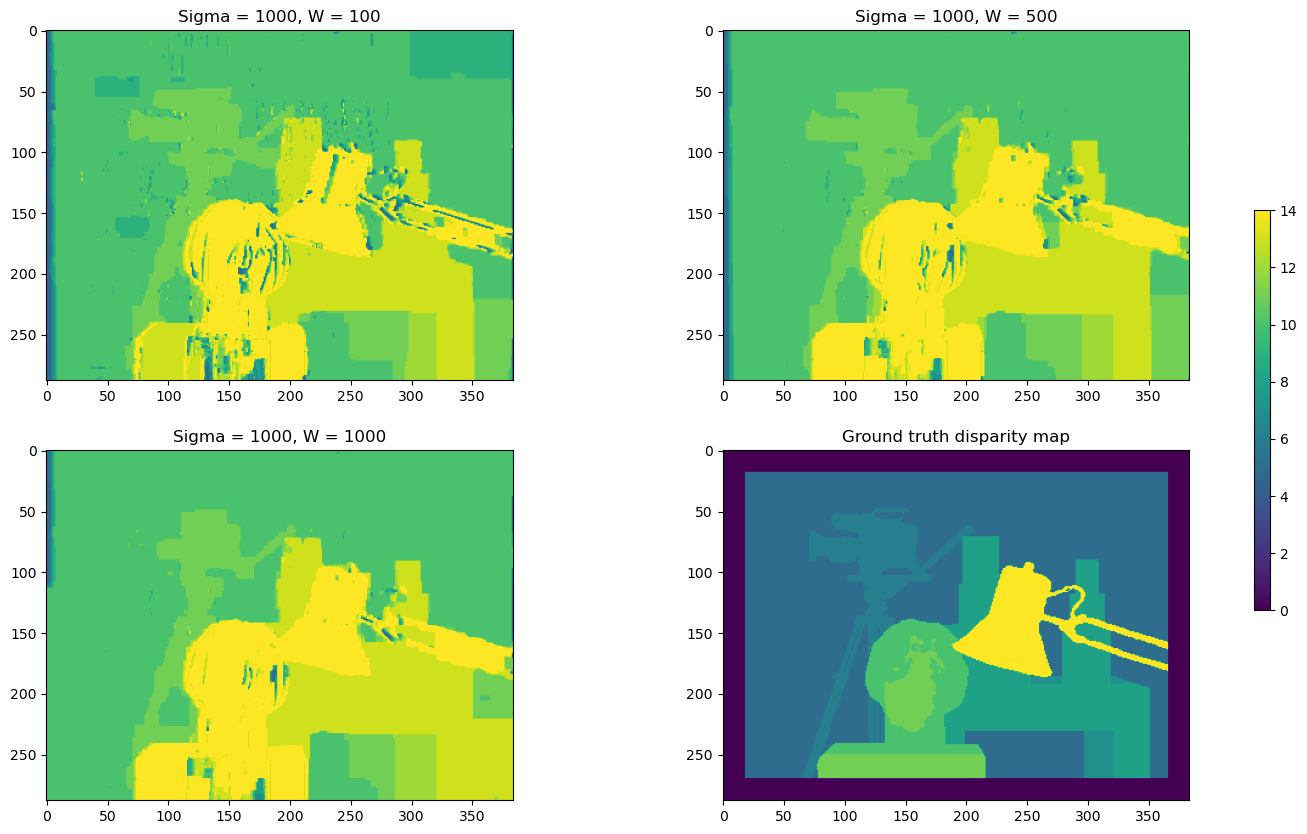

In [7]:
sigmas = np.array([1000])
ws = np.array([100, 500, 1000])

fig = plt.figure(figsize = (16,10))
plt.subplot(221)
plt.title("Sigma = {0}, W = {1}".format(sigmas[0], ws[0]))
plt.imshow(disparity_grid(im_left, im_right, d_min, d_max, sigmas[0], ws[0]),vmin=0, vmax=d_max)
plt.subplot(222)
plt.title("Sigma = {0}, W = {1}".format(sigmas[0], ws[1]))
plt.imshow(disparity_grid(im_left, im_right, d_min, d_max, sigmas[0], ws[1]),vmin=0, vmax=d_max)
plt.subplot(223)
plt.title("Sigma = {0}, W = {1}".format(sigmas[0], ws[2]))
plt.imshow(disparity_grid(im_left, im_right, d_min, d_max, sigmas[0], ws[2]),vmin=0, vmax=d_max)
plt.subplot(224)
plt.title("Ground truth disparity map")
plt.imshow(im_gt/16,vmin=0, vmax=d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

With $w = 100$ we are able to observe some noise in the background as well as within the statue and lamp objects. With $w = 1000$ we can see that the camera object near the background is missing a chunk of its boundaries. It appears that the new result with $\sigma = 1000, w = 500$ has the best balance between reduced noise and clarity of object boundaries. Of course, the hyperparameters can be tuned even more precisely, but there won't be significant improvement in the disparity map from the current best result with $\sigma = 1000, w = 500$.

## Comparison with window based stereo
In this section, we will compare the results of window based stereo with the full-grid stereo. We will use two different window sizes and see how they compare to the full-grid stereo result.

In [8]:
dispMap_small = Dmap_Windows(im_left, im_right, d_min, d_max, 4)
dispMap_large = Dmap_Windows(im_left, im_right, d_min, d_max, 15)
disp_grid = disparity_grid(im_left, im_right, d_min, d_max, 1000, 500)

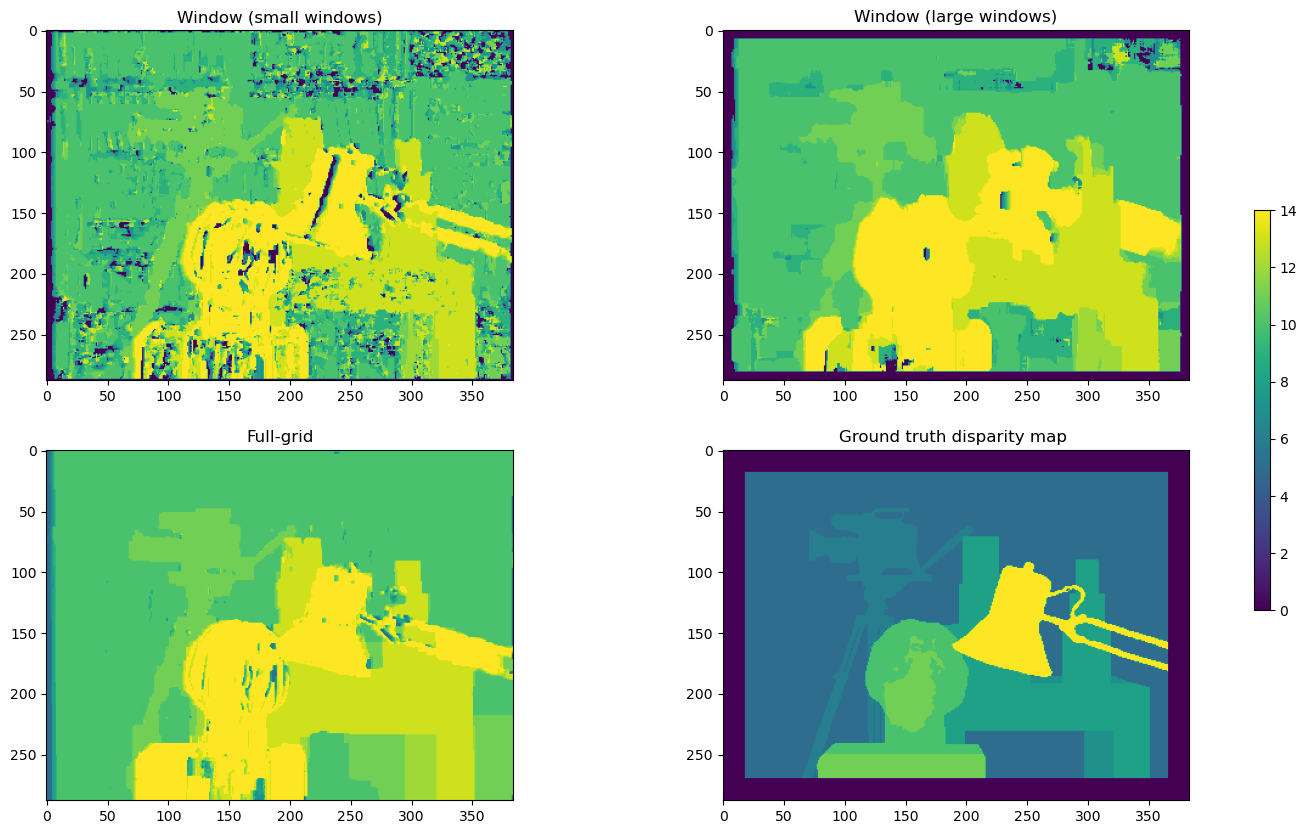

In [9]:
fig = plt.figure(figsize = (16, 10))
plt.subplot(221)
plt.title("Window (small windows)")
plt.imshow(dispMap_small, vmin = 0, vmax = d_max)
plt.subplot(222)
plt.title("Window (large windows)")
plt.imshow(dispMap_large, vmin = 0, vmax = d_max)
plt.subplot(223)
plt.title("Full-grid")
plt.imshow(disp_grid, vmin = 0, vmax = d_max) 
plt.subplot(224) 
plt.title("Ground truth disparity map ")
plt.imshow(im_gt/16, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

Comparing the two window based results with each other, the disparity map using small window appears noisy and shows clear object boundaries while the disparity map using large window appears less noisy with less defined object boundaries. Comparing these with the full-grid stereo disparity map, we can observe that the full-grid disparity map is less noisy compared to the large window disparity map while having just as clear object boundaries compared to the small window disparity map. Therefore, the full-grid stereo easily outperforms the window based stereo, in terms of both reduced noise and clear boundaries. 

## Comparison with scanline stereo

In this section, we will compare the results of scanline stereo using Viterbi algorithm with the full-grid stereo. In order to maintain consistency, the same value of $w$ will be applied to both scanline and full-grid stereo. We will also consider the case where the photoconsistency term is computed for a window around each pixel, for a few different window sizes. 

In [10]:
w = 500
window_sizes = np.array([3, 5, 7])
Viterbi_map = Viterbi_wrapper(im_left, im_right, d_min, d_max, w)
Viterbi_map1 = Viterbi_wrapper_wind(im_left, im_right, d_min, d_max, w, window_sizes[0])
Viterbi_map2 = Viterbi_wrapper_wind(im_left, im_right, d_min, d_max, w, window_sizes[1])
Viterbi_map3 = Viterbi_wrapper_wind(im_left, im_right, d_min, d_max, w, window_sizes[2])

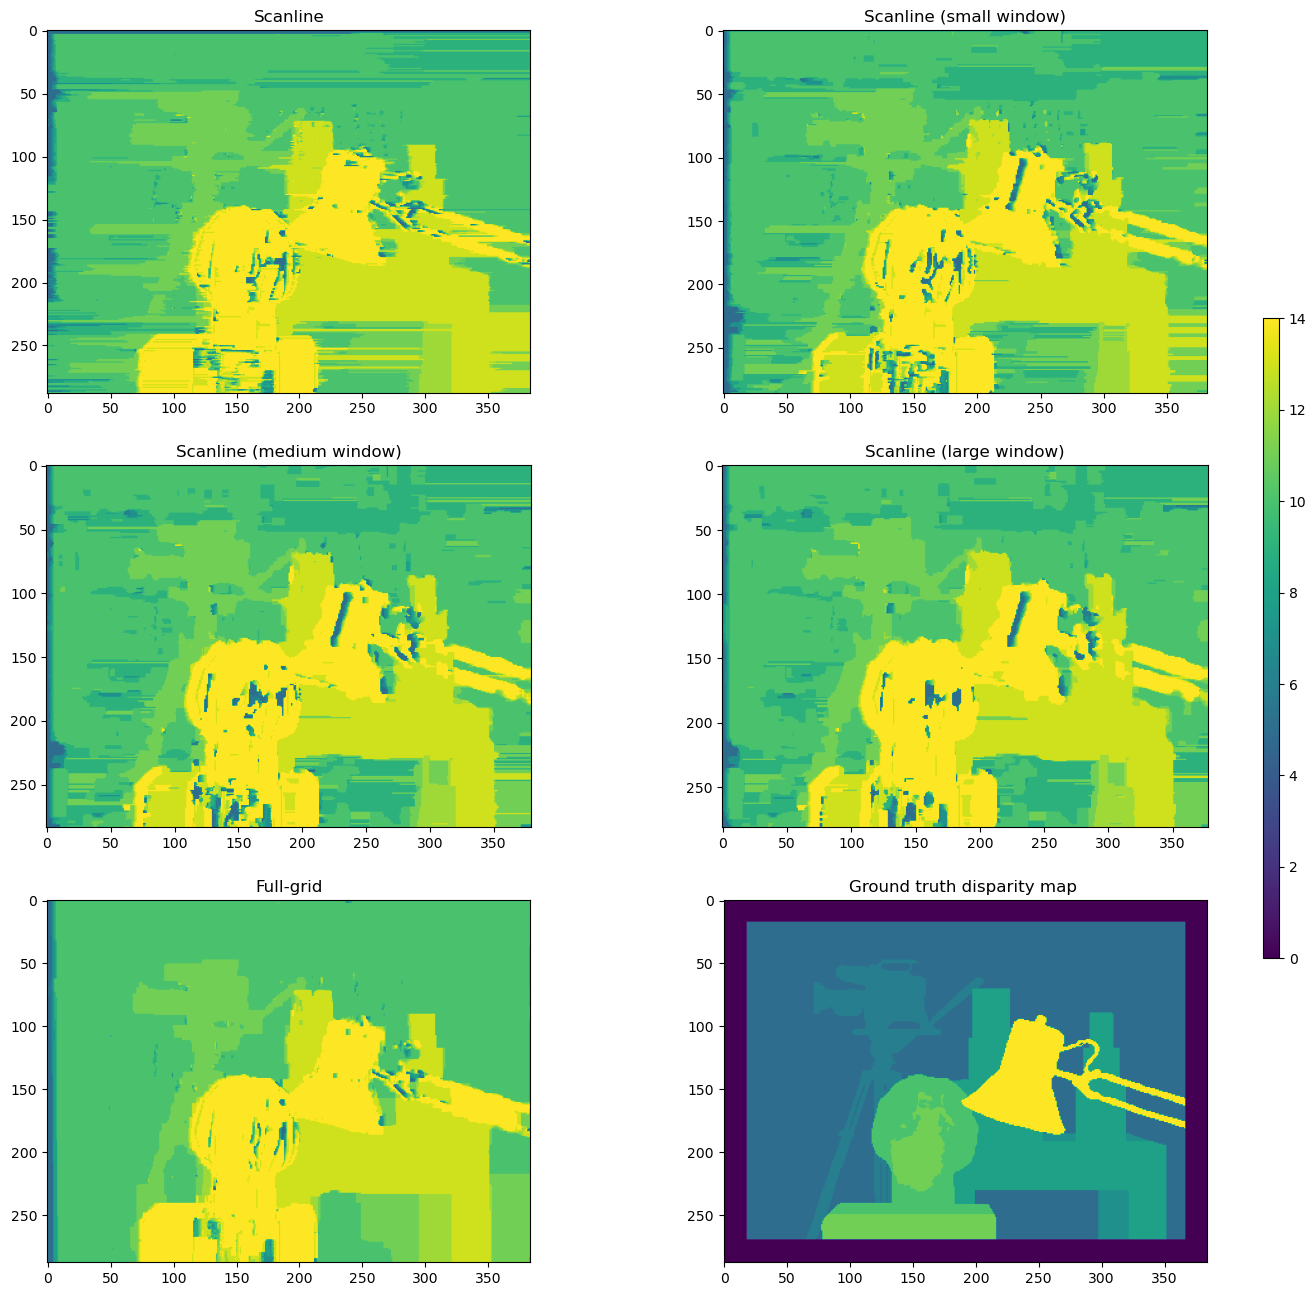

In [11]:
fig = plt.figure(figsize = (16, 16))
plt.subplot(321)
plt.title("Scanline")
plt.imshow(Viterbi_map, vmin = 0, vmax = d_max)
plt.subplot(322)
plt.title("Scanline (small window)")
plt.imshow(Viterbi_map1, vmin = 0, vmax = d_max)
plt.subplot(323)
plt.title("Scanline (medium window)")
plt.imshow(Viterbi_map2, vmin = 0, vmax = d_max)
plt.subplot(324)
plt.title("Scanline (large window)")
plt.imshow(Viterbi_map3, vmin = 0, vmax = d_max)
plt.subplot(325)
plt.title("Full-grid")
plt.imshow(disp_grid, vmin = 0, vmax = d_max) 
plt.subplot(326) 
plt.title("Ground truth disparity map ")
plt.imshow(im_gt/16, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

In the original scanline stereo, we can see the artifact of optimizing across scanlines - the horizontal streaks all over the disparity map. As we introduce window to the scanline stereo and increase the size of the window, this artifact is significantly reduced. However, it appears to come at the cost of more blurry edges. Comparing these results to that from full-grid stereo, we can see that full-grid stereo provides clear edges that is just as good as that from scanline stereo without windows, but with no horizontal streaks and almost no noise.

## Comparison with scanline stereo with local intensity contrast

In this section, we will compare the results of scanline stereo where regularization weights depend on the neighbouring pixels. In particular, similar to problem 8 from A3, we will use local intensity contrast that weighs the regularization parameter $w$ by a Gaussian kernel. 

$$ w_{pq} = w exp{\frac{-\|I_p-I_q\|^2}{2\sigma^2}}$$

Note that this introduces another hyperparameter $\sigma$, and this is very similar to what is being performed within the full-grid stereo implementation where the spatial consistency cost is calculated as edge weights for each layer of disparity level. We will use the same values for hyperparameters $\sigma, w$ for more consistent comparison of the results

In [12]:
Viterbi_gaus1 = Viterbi_wrapper_kernel(im_left, im_right, d_min, d_max, w, 100)
Viterbi_gaus2 = Viterbi_wrapper_kernel(im_left, im_right, d_min, d_max, w, 500)
Viterbi_gaus3 = Viterbi_wrapper_kernel(im_left, im_right, d_min, d_max, w, 1000)
disp_grid1 = disparity_grid(im_left, im_right, d_min, d_max, 100, w)
disp_grid2 = disparity_grid(im_left, im_right, d_min, d_max, 500, w)
disp_grid3 = disparity_grid(im_left, im_right, d_min, d_max, 1000, w)

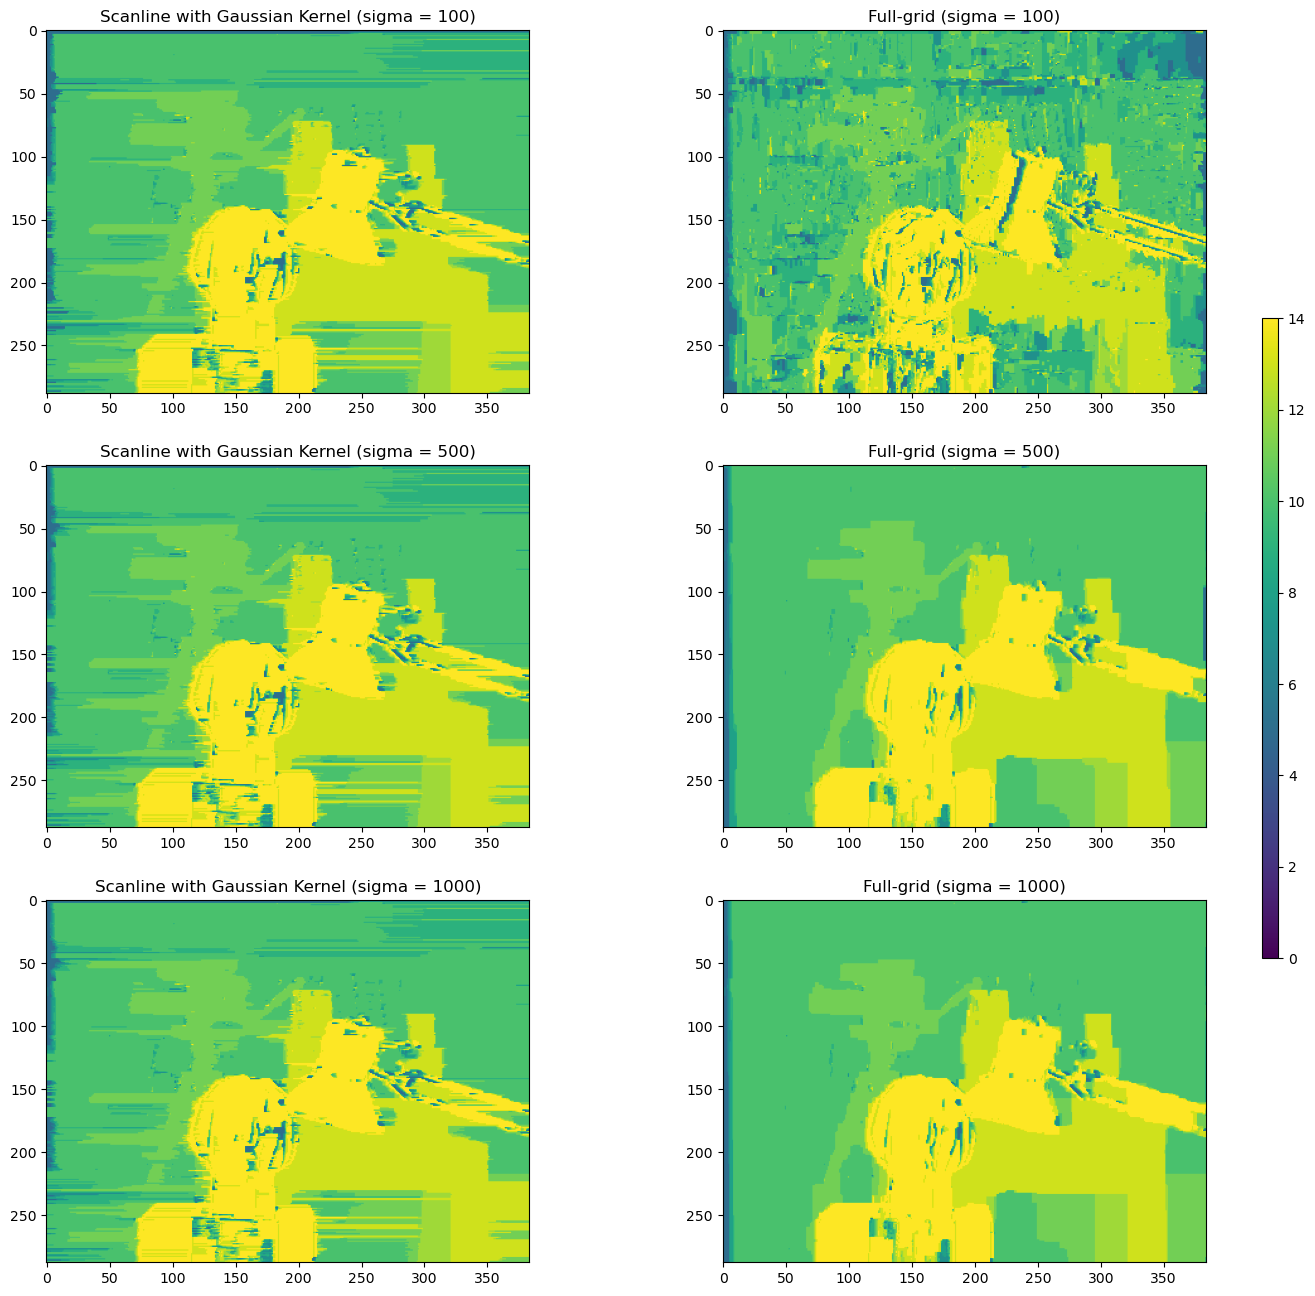

In [13]:
fig = plt.figure(figsize = (16, 16))
plt.subplot(321)
plt.title("Scanline with Gaussian Kernel (sigma = 100)")
plt.imshow(Viterbi_gaus1, vmin = 0, vmax = d_max)
plt.subplot(322)
plt.title("Full-grid (sigma = 100)")
plt.imshow(disp_grid1, vmin = 0, vmax = d_max)
plt.subplot(323)
plt.title("Scanline with Gaussian Kernel (sigma = 500)")
plt.imshow(Viterbi_gaus2, vmin = 0, vmax = d_max)
plt.subplot(324)
plt.title("Full-grid (sigma = 500)")
plt.imshow(disp_grid2, vmin = 0, vmax = d_max)
plt.subplot(325)
plt.title("Scanline with Gaussian Kernel (sigma = 1000)")
plt.imshow(Viterbi_gaus3, vmin = 0, vmax = d_max) 
plt.subplot(326) 
plt.title("Full-grid (sigma = 1000)")
plt.imshow(disp_grid3, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

We observe that as $\sigma$ increases in value, the streaking artifacts in disparity maps of scanline with Gaussian kernel remain. This makes sense, since we are still only matching disparities within each scanlines. In full-grid stereo, we observe a lot of noise for $\sigma = 100$, but as we increase $\sigma$ we observe significant reduction in noise and we also observe that the boundaries of objects remain clear. 

## Comparison with scanline stereo with quadratic and truncated-quadratic regularization

In this section, we will compare the results of scanline stereo with quadratic and truncated-quadratic regularizations given by $V_{pq}(d_p, d_q) = w_{pq}|d_p-d_q|^2$ and $V_{pq}(d_p, d_q) = w_{pq} min\{|d_p - d_q|, T\}$ respectively. Similar to the previous part, we will use the same values for hyperparameters $\sigma, w$ for more consistent comparison of the results.

In [14]:
Viterbi_q1 = Viterbi_wrapper_quad(im_left, im_right, d_min, d_max, w, 100)
Viterbi_q2 = Viterbi_wrapper_quad(im_left, im_right, d_min, d_max, w, 500)
Viterbi_q3 = Viterbi_wrapper_quad(im_left, im_right, d_min, d_max, w, 1000)

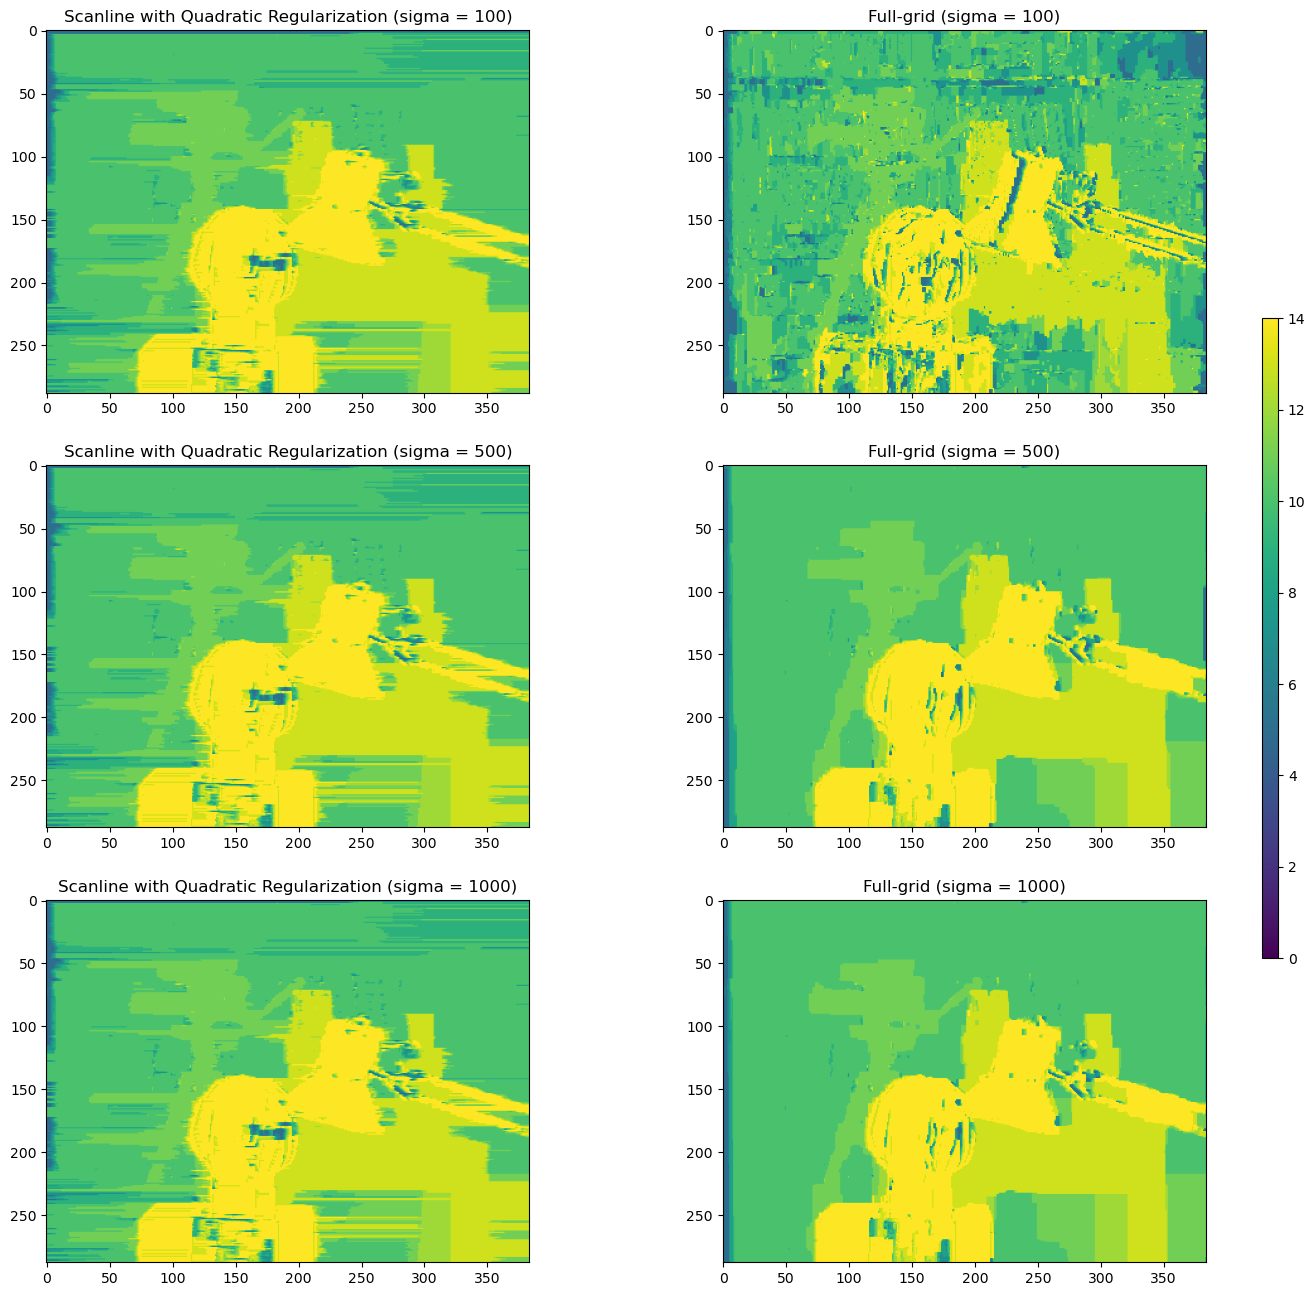

In [15]:
fig = plt.figure(figsize = (16, 16))
plt.subplot(321)
plt.title("Scanline with Quadratic Regularization (sigma = 100)")
plt.imshow(Viterbi_q1, vmin = 0, vmax = d_max)
plt.subplot(322)
plt.title("Full-grid (sigma = 100)")
plt.imshow(disp_grid1, vmin = 0, vmax = d_max)
plt.subplot(323)
plt.title("Scanline with Quadratic Regularization (sigma = 500)")
plt.imshow(Viterbi_q2, vmin = 0, vmax = d_max)
plt.subplot(324)
plt.title("Full-grid (sigma = 500)")
plt.imshow(disp_grid2, vmin = 0, vmax = d_max)
plt.subplot(325)
plt.title("Scanline with Quadratic Regularization (sigma = 1000)")
plt.imshow(Viterbi_q3, vmin = 0, vmax = d_max) 
plt.subplot(326) 
plt.title("Full-grid (sigma = 1000)")
plt.imshow(disp_grid3, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

When comparing the results between quadratic regularization and full-grid stereo, we again observe horizontal streaking artifacts in the quadratic regularization disparity maps. The full-grid stereo shows no such artifacts and provides even clearer object boundaries due to the lack of such artifacts. 

In [16]:
Viterbi_tq1 = Viterbi_wrapper_tquad(im_left, im_right, d_min, d_max, w, 100, 1)
Viterbi_tq2 = Viterbi_wrapper_tquad(im_left, im_right, d_min, d_max, w, 500, 1)
Viterbi_tq3 = Viterbi_wrapper_tquad(im_left, im_right, d_min, d_max, w, 1000, 1)
Viterbi_tq4 = Viterbi_wrapper_tquad(im_left, im_right, d_min, d_max, w, 100, 20)
Viterbi_tq5 = Viterbi_wrapper_tquad(im_left, im_right, d_min, d_max, w, 500, 20)
Viterbi_tq6 = Viterbi_wrapper_tquad(im_left, im_right, d_min, d_max, w, 1000, 20)

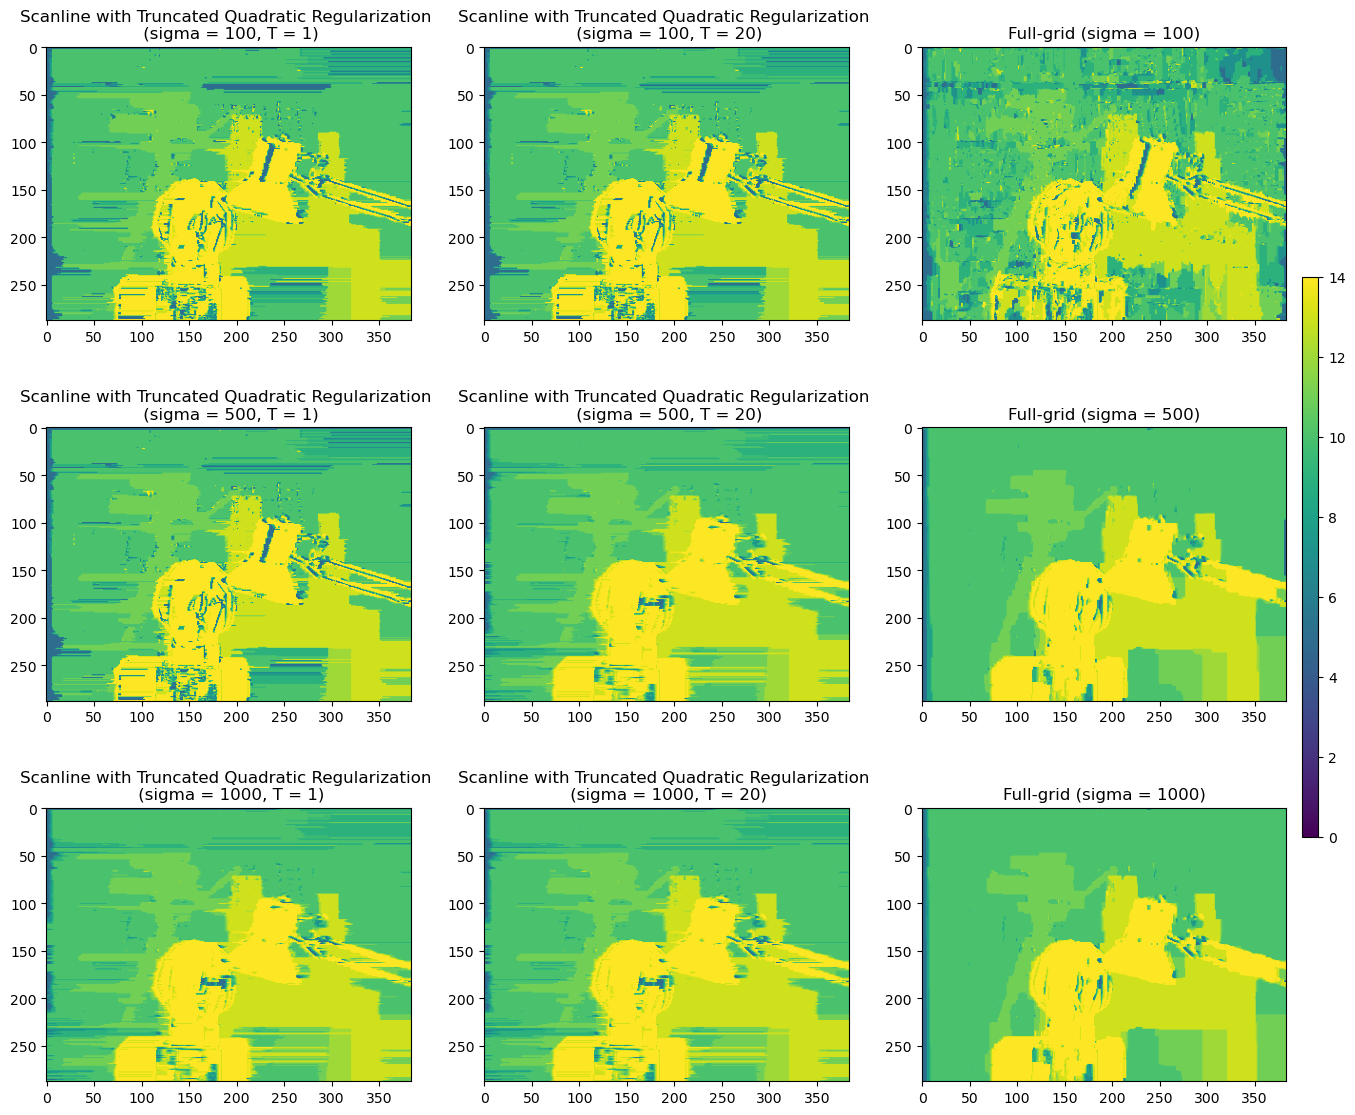

In [17]:
fig = plt.figure(figsize = (16, 14))
plt.subplot(331)
plt.title("Scanline with Truncated Quadratic Regularization \n (sigma = 100, T = 1)")
plt.imshow(Viterbi_tq1, vmin = 0, vmax = d_max)
plt.subplot(332)
plt.title("Scanline with Truncated Quadratic Regularization \n (sigma = 100, T = 20)")
plt.imshow(Viterbi_tq2, vmin = 0, vmax = d_max)
plt.subplot(333)
plt.title("Full-grid (sigma = 100)")
plt.imshow(disp_grid1, vmin = 0, vmax = d_max)
plt.subplot(334)
plt.title("Scanline with Truncated Quadratic Regularization \n (sigma = 500, T = 1)")
plt.imshow(Viterbi_tq3, vmin = 0, vmax = d_max)
plt.subplot(335)
plt.title("Scanline with Truncated Quadratic Regularization \n (sigma = 500, T = 20)")
plt.imshow(Viterbi_tq4, vmin = 0, vmax = d_max)
plt.subplot(336)
plt.title("Full-grid (sigma = 500)")
plt.imshow(disp_grid2, vmin = 0, vmax = d_max)
plt.subplot(337)
plt.title("Scanline with Truncated Quadratic Regularization \n (sigma = 1000, T = 1)")
plt.imshow(Viterbi_tq5, vmin = 0, vmax = d_max)
plt.subplot(338)
plt.title("Scanline with Truncated Quadratic Regularization \n (sigma = 1000, T = 20)")
plt.imshow(Viterbi_tq6, vmin = 0, vmax = d_max)
plt.subplot(339)
plt.title("Full-grid (sigma = 1000)")
plt.imshow(disp_grid3, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

When comparing the results between truncated quadratic regularization and full-grid stereo, we still observe horizontal streaking artifacts in the truncated quadratic regularization disparity maps. However, with increasing values of $T$, we observe less noise within the object. For example, comparing the disparity maps between $\sigma = 500, T=1$ and $\sigma = 500, T = 20$, we observe more uniform disparity level within the statue object in the disparity map with $T = 20$. However, compared to the disparity maps of full-grid stereo, truncated quadratic regularization provides much more noisy results with the horizontal streaks. 

## Conclusion



The full-grid stereo demonstrated superior performance in finding optimal disparity maps relative to any of the scanline stereo or window based stereo methods used in A3. Relative to the disparity maps of scanline stereo, the full-grid stereo showed no horizontal streaks as it optimized over both the horizontal and vertical scanlines whereas the scanline stereo only optimize across horizontal scanlines. Full-grid stereo was also much less noisy compared to window based methods with small window size and showed much more defined object boundaries compared to window based methods with large window size. 

One obstacle that was faced with the full-grid stereo is memory constraints. When building the 3D graph for full-grid stereo, the number of nodes is $image\_width \times image\_height \times disparity\_levels$. When given a large image with many disparity levels, the number of nodes and the number of edges explode very quickly. I was faced with dead kernels when running my implementation of full-grid stereo on larger images from the Middleburry dataset because my memory could not handle the number of edges I was adding to the graph. In this sense, scanline stereo may work better as it only considers one horizontal row of pixels at a time, hence the size of the data handled at once is much smaller compared to the full-grid stereo. However, optimizing over a row at a time will again result in artifacts of horizontal streaks. 

Overall, I am very happy with the results of my full-grid stereo. It runs fast and it provides disparity maps with low noise and clear object boundaries. With some tuning of the hyperparameters, the full-grid stereo implementation is able to closely resemble the ground truth disparity map. 